In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(["science", "nature"])

%matplotlib inline

## Load results

In [3]:
all_out = glob("out/**/*.pkl")

In [4]:
all_out = [load_pickle(p) for p in all_out]

In [5]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out:
    try:
        res = {
            "train_size": out["train_size"],
            "frac_valid": out["frac_valid"],
            "accuracy": out["accuracy"],
            "f1_macro": out["f1_macro"],
            "f1_micro": out["f1_micro"],
            "kappa": out["kappa"],
            "num_classes": out["num_classes"],
            "representation": out["representation"],
        }
        extracted_res.append(res)
    except KeyError:
        pass

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["xgboost_baseline"]["accuracy"],
        "f1_macro": out["xgboost_baseline"]["f1_macro"],
        "f1_micro": out["xgboost_baseline"]["f1_micro"],
        "kappa": out["xgboost_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["tabpfn_baseline"]["accuracy"],
        "f1_macro": out["tabpfn_baseline"]["f1_macro"],
        "f1_micro": out["tabpfn_baseline"]["f1_micro"],
        "kappa": out["tabpfn_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)

In [6]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [7]:
grouped_res = res.groupby(["num_classes", "representation", "train_size"]).agg(
    ["mean", "std", "count", sem]
)

In [8]:
grouped_xgboost_res = xgboost_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

In [9]:
grouped_tabpfn_res = tabpfn_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

In [10]:
grouped_res.loc[2, :]

frac_valid                            accuracy  \
                                mean       std count       sem      mean   
representation train_size                                                  
InChI          10           0.833333  0.408248     6  0.166667  0.479333   
               50           0.857143  0.377964     7  0.142857  0.539429   
               100          0.857143  0.377964     7  0.142857  0.549714   
               200          0.875000  0.353553     8  0.125000  0.582000   
               500          1.000000  0.000000     7  0.000000  0.686857   
               1000         1.000000       NaN     1       NaN  0.644000   
SELFIES        10           0.833333  0.408248     6  0.166667  0.443333   
               50           0.857143  0.377964     7  0.142857  0.504571   
               100          0.857143  0.377964     7  0.142857  0.549143   
               200          0.875000  0.353553     8  0.125000  0.573500   
               500          0.875000  0.353553     8  0.125000  0.607000   
               1000         1.000000       NaN     1       NaN  0.696000   
SMILES         10           0.857143  0.377964     7  0.142857  0.476571   
               50           0.857143  0.377964     7  0.142857  0.518286   
               100          0.857143  0.377964     7  0.142857  0.562857   
               200          0.875000  0.353553     8  0.125000  0.588000   
               500          0.874500  0.353354     8  0.124930  0.623865   
               1000         1.000000       NaN     1       NaN  0.704000   

                                                     f1_macro                  \
                                std count       sem      mean       std count   
representation train_size                                                       
InChI          10          0.236933     6  0.096727  0.454918  0.229483     6   
               50          0.239616     7  0.090566  0.537949  0.238924     7   
               100         0.244239     7  0.092314  0.548402  0.243619     7   
               200         0.237511     8  0.083973  0.581168  0.237187     8   
               500         0.023745     7  0.008975  0.686309  0.023714     7   
               1000             NaN     1       NaN  0.643309       NaN     1   
SELFIES        10          0.222271     6  0.090742  0.414725  0.221651     6   
               50          0.226856     7  0.085743  0.500993  0.226136     7   
               100         0.245316     7  0.092721  0.547334  0.244654     7   
               200         0.233453     8  0.082538  0.571641  0.232740     8   
               500         0.247518     8  0.087511  0.606876  0.247471     8   
               1000             NaN     1       NaN  0.696000       NaN     1   
SMILES         10          0.213547     7  0.080713  0.434121  0.207634     7   
               50          0.233556     7  0.088276  0.516252  0.233038     7   
               100         0.250245     7  0.094584  0.559786  0.249048     7   
               200         0.238586     8  0.084353  0.586616  0.237971     8   
               500         0.252926     8  0.089423  0.623558  0.252831     8   
               1000             NaN     1       NaN  0.703924       NaN     1   

                                     f1_micro                            \
                                sem      mean       std count       sem   
representation train_size                                                 
InChI          10          0.093686  0.479333  0.236933     6  0.096727   
               50          0.090305  0.539429  0.239616     7  0.090566   
               100         0.092079  0.549714  0.244239     7  0.092314   
               200         0.083858  0.582000  0.237511     8  0.083973   
               500         0.008963  0.686857  0.023745     7  0.008975   
               1000             NaN  0.644000       NaN     1       NaN   
SELFIES        10          0.090488  0.443333  0.222

In [11]:
grouped_tabpfn_res

accuracy                      f1_macro            \
                            mean       std       sem      mean       std   
num_classes train_size                                                     
2           10          0.556182  0.027143  0.005787  0.540973  0.040501   
            50          0.561000  0.027238  0.005560  0.558191  0.029964   
            100         0.582333  0.025840  0.005275  0.581697  0.025802   
            200         0.605333  0.026695  0.005137  0.604675  0.027105   
            500         0.628000  0.045122  0.009024  0.626998  0.045894   
            1000        0.644000  0.000000  0.000000  0.643858  0.000000   
5           10          0.220000  0.029148  0.006361  0.207449  0.033101   
            50          0.236000  0.026833  0.005855  0.228163  0.024369   
            100         0.257714  0.034002  0.007420  0.238201  0.038085   
            200         0.296400  0.030516  0.006823  0.273130  0.035190   
            500         0.340000  0.025267  0.005514  0.310946  0.022472   
            1000        0.300000  0.000000  0.000000  0.288270  0.000000   

                                  f1_micro                         kappa  \
                             sem      mean       std       sem      mean   
num_classes train_size                                                     
2           10          0.008635  0.556182  0.027143  0.005787  0.112364   
            50          0.006116  0.561000  0.027238  0.005560  0.122000   
            100         0.005267  0.582333  0.025840  0.005275  0.164667   
            200         0.005216  0.605333  0.026695  0.005137  0.210667   
            500         0.009179  0.628000  0.045122  0.009024  0.256000   
            1000        0.000000  0.644000  0.000000  0.000000  0.288000   
5           10          0.007223  0.220000  0.029148  0.006361  0.025000   
            50          0.005318  0.236000  0.026833  0.005855  0.045000   
            100         0.008311  0.257714  0.034002  0.007420  0.072143   
            200         0.007869  0.296400  0.030516  0.006823  0.120500   
            500         0.004904  0.340000  0.025267  0.005514  0.175000   
            1000        0.000000  0.300000  0.000000  0.000000  0.125000   

                                            
                             std       sem  
num_classes train_size                      
2           10          0.054285  0.011574  
            50          0.054476  0.011120  
            100         0.051680  0.010549  
            200         0.053390  0.010275  
            500         0.090244  0.018049  
            1000        0.000000  0.000000  
5           10          0.036435  0.007951  
            50          0.033541  0.007319  
            100         0.042502  0.009275  
            200         0.038144  0.008529  
            500         0.031583  0.006892  
            1000        0.000000  0.000000

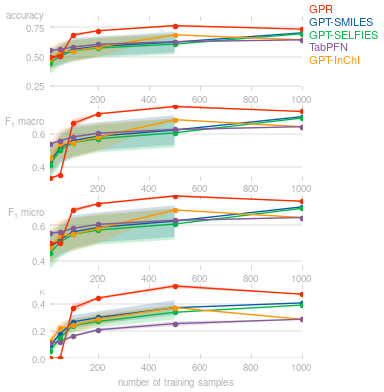

In [12]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[2, "SMILES", :].index,
            grouped_res.loc[2, "SMILES", :][metric]["mean"],
            marker="o",
            label="GPT-SMILES",
        )
        ax[i].fill_between(
            grouped_res.loc[2, "SMILES", :].index,
            grouped_res.loc[2, "SMILES", :][metric]["mean"]
            - grouped_res.loc[2, "SMILES", :][metric]["sem"],
            grouped_res.loc[2, "SMILES", :][metric]["mean"]
            + grouped_res.loc[2, "SMILES", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[2, "SELFIES", :].index,
            grouped_res.loc[2, "SELFIES", :][metric]["mean"],
            marker="o",
            label="GPT-SELFIES",
        )
        ax[i].fill_between(
            grouped_res.loc[2, "SELFIES", :].index,
            grouped_res.loc[2, "SELFIES", :][metric]["mean"]
            - grouped_res.loc[2, "SELFIES", :][metric]["sem"],
            grouped_res.loc[2, "SELFIES", :][metric]["mean"]
            + grouped_res.loc[2, "SELFIES", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[2, "InChI", :].index,
            grouped_res.loc[2, "InChI", :][metric]["mean"],
            marker="o",
            label="GPT-InChI",
        )
        ax[i].fill_between(
            grouped_res.loc[2, "InChI", :].index,
            grouped_res.loc[2, "InChI", :][metric]["mean"]
            - grouped_res.loc[2, "InChI", :][metric]["sem"],
            grouped_res.loc[2, "InChI", :][metric]["mean"]
            + grouped_res.loc[2, "InChI", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[2, :].index,
            grouped_xgboost_res.loc[2, :][metric]["mean"],
            marker="o",
            label="GPR",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[2, :].index,
            grouped_xgboost_res.loc[2, :][metric]["mean"]
            - grouped_xgboost_res.loc[2, :][metric]["sem"],
            grouped_xgboost_res.loc[2, :][metric]["mean"]
            + grouped_xgboost_res.loc[2, :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[2, :].index,
            grouped_tabpfn_res.loc[2, :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[2, :].index,
            grouped_tabpfn_res.loc[2, :][metric]["mean"]
            - grouped_tabpfn_res.loc[2, :][metric]["sem"],
            grouped_tabpfn_res.loc[2, :][metric]["mean"]
            + grouped_tabpfn_res.loc[2, :][metric]["sem"],
            alpha=0.2,
        )

    ax[-1].set_xlabel("number of training samples", labelpad=4)
    matplotx.line_labels(ax=ax[0], fontsize=8)
    ax[0].set_ylim(0.21, 0.85)
    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])

    fig.savefig("bandgap-classification_results_2_class.pdf", bbox_inches="tight")

In [13]:
find_learning_curve_intersection(
    grouped_res.loc[2, "InChI", :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

5.078797842952562

In [14]:
find_learning_curve_intersection(
    grouped_res.loc[2, "InChI", :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

0.6176498622137961

In [15]:
intersections = []

for i, val in enumerate(grouped_res.loc[2, "SMILES", :].index):
    factor= find_learning_curve_intersection(
    grouped_res.loc[2, "SMILES", :]["f1_macro"]["mean"].values[i],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / val

    intersections.append(factor)

intersections_tabpfn = []

for i, val in enumerate(grouped_res.loc[2, "SMILES", :].index):
    factor= find_learning_curve_intersection(
    grouped_res.loc[2, "SMILES", :]["f1_macro"]["mean"].values[i],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / val

    intersections_tabpfn.append(factor)

In [16]:
from gptchem.evaluator import add_kappa_vlines

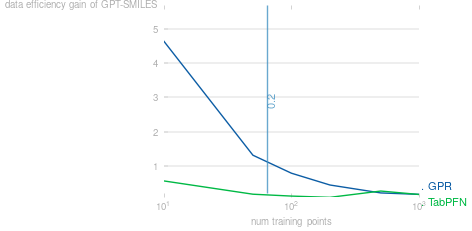

In [17]:
with plt.style.context(matplotx.styles.dufte):
    plt.plot(grouped_res.loc[2, "SMILES", :].index, intersections, label=' . GPR')
    plt.plot(grouped_res.loc[2, "SMILES", :].index, intersections_tabpfn, label=' . TabPFN')
    matplotx.line_labels(fontsize=8)
    add_kappa_vlines(grouped_res.loc[2, "SMILES", :].index, grouped_res.loc[2, "SMILES", :]["kappa"]["mean"], ymax=5.7)
    matplotx.ylabel_top('data efficiency gain  of GPT-SMILES')
    plt.xlabel('num training points', labelpad=4)

    plt.xscale('log')
    plt.savefig('bandgap-binary-data-efficiency.pdf', bbox_inches='tight')

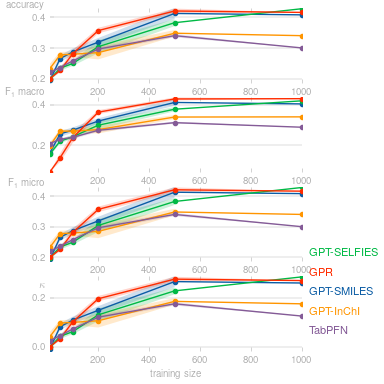

In [18]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[5, "SMILES", :].index,
            grouped_res.loc[5, "SMILES", :][metric]["mean"],
            marker="o",
            label="GPT-SMILES",
        )
        ax[i].fill_between(
            grouped_res.loc[5, "SMILES", :].index,
            grouped_res.loc[5, "SMILES", :][metric]["mean"]
            - grouped_res.loc[5, "SMILES", :][metric]["sem"],
            grouped_res.loc[5, "SMILES", :][metric]["mean"]
            + grouped_res.loc[5, "SMILES", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[5, "SELFIES", :].index,
            grouped_res.loc[5, "SELFIES", :][metric]["mean"],
            marker="o",
            label="GPT-SELFIES",
        )
        ax[i].fill_between(
            grouped_res.loc[5, "SELFIES", :].index,
            grouped_res.loc[5, "SELFIES", :][metric]["mean"]
            - grouped_res.loc[5, "SELFIES", :][metric]["sem"],
            grouped_res.loc[5, "SELFIES", :][metric]["mean"]
            + grouped_res.loc[5, "SELFIES", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_res.loc[5, "InChI", :].index,
            grouped_res.loc[5, "InChI", :][metric]["mean"],
            marker="o",
            label="GPT-InChI",
        )
        ax[i].fill_between(
            grouped_res.loc[5, "InChI", :].index,
            grouped_res.loc[5, "InChI", :][metric]["mean"]
            - grouped_res.loc[5, "InChI", :][metric]["sem"],
            grouped_res.loc[5, "InChI", :][metric]["mean"]
            + grouped_res.loc[5, "InChI", :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[5, :].index,
            grouped_xgboost_res.loc[5, :][metric]["mean"],
            marker="o",
            label="GPR",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[5, :].index,
            grouped_xgboost_res.loc[5, :][metric]["mean"]
            - grouped_xgboost_res.loc[5, :][metric]["sem"],
            grouped_xgboost_res.loc[5, :][metric]["mean"]
            + grouped_xgboost_res.loc[5, :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[5, :].index,
            grouped_tabpfn_res.loc[5, :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[5, :].index,
            grouped_tabpfn_res.loc[5, :][metric]["mean"]
            - grouped_tabpfn_res.loc[5, :][metric]["sem"],
            grouped_tabpfn_res.loc[5, :][metric]["mean"]
            + grouped_tabpfn_res.loc[5, :][metric]["sem"],
            alpha=0.2,
        )

    ax[-1].set_xlabel("training size", labelpad=4)
    matplotx.line_labels(ax[-1], fontsize=8)

    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])

    fig.savefig("bandgap-classification_results_5_class.pdf", bbox_inches="tight")

In [19]:
intersections = []

for i, val in enumerate(grouped_res.loc[5, "SMILES", :].index):
    factor= find_learning_curve_intersection(
    grouped_res.loc[5, "SMILES", :]["f1_macro"]["mean"].values[i],
    fit_learning_curve(
        grouped_xgboost_res.loc[5, :].index,
        grouped_xgboost_res.loc[5, :]["f1_macro"]["mean"],
    )[0],
) / val

    intersections.append(factor)

intersections_tabpfn = []

for i, val in enumerate(grouped_res.loc[5, "SMILES", :].index):
    factor= find_learning_curve_intersection(
    grouped_res.loc[5, "SMILES", :]["f1_macro"]["mean"].values[i],
    fit_learning_curve(
        grouped_tabpfn_res.loc[5, :].index,
        grouped_tabpfn_res.loc[5, :]["f1_macro"]["mean"],
    )[0],
) / val

    intersections_tabpfn.append(factor)

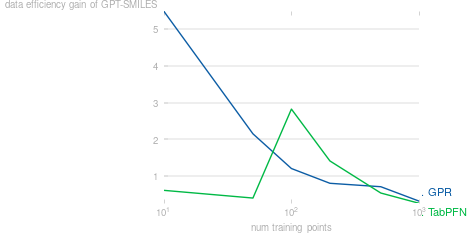

In [20]:
with plt.style.context(matplotx.styles.dufte):
    plt.plot(grouped_res.loc[5, "SMILES", :].index, intersections, label=' . GPR')
    plt.plot(grouped_res.loc[5, "SMILES", :].index, intersections_tabpfn, label=' . TabPFN')
    matplotx.line_labels(fontsize=8)

    matplotx.ylabel_top('data efficiency gain  of GPT-SMILES')
    plt.xlabel('num training points', labelpad=4)
    add_kappa_vlines(grouped_res.loc[5, "SMILES", :].index, grouped_res.loc[5, "SMILES", :]["kappa"]["mean"], ymax=5.7)
    plt.xscale('log')
    plt.savefig('bandgap-5-data-efficiency.pdf', bbox_inches='tight')